In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
from itertools import chain
import seaborn as sns
import tensorflow as tf
import scipy
import sklearn.model_selection as skl

from random import sample
from skimage import io

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve,roc_auc_score, auc, precision_score,precision_recall_curve, average_precision_score

## Do some early processing of your metadata for easier model training:

In [39]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')



In [40]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1:
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df.sample(3)        

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
28575  00007452_001.png     No Finding            1        7452           60   
22521  00005966_009.png    Atelectasis            9        5966           51   
22663  00005993_013.png     No Finding           13        5993           79   

      Patient Gender View Position  OriginalImage[Width  Height]  \
28575              M            AP                 2500     2048   
22521              F            PA                 2048     2500   
22663              M            AP                 2500     2048   

       OriginalImagePixelSpacing[x  ...  Emphysema  Fibrosis  Hernia  \
28575                        0.168  ...          0         0       0   
22521                        0.171  ...          0         0       0   
22663                        0.168  ...          0         0       0   

       Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  \
28575             0     0           1       0                   0          0   
22521             0     0           0       0                   0          0   
22663             0     0           1       0                   0          0   

       Pneumothorax  
28575             0  
22521             0  
22663             0  

[3 rows x 27 columns]

In [41]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['image_path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
88876   00022033_000.png     No Finding            0       22033           28   
10896   00002834_004.png     No Finding            4        2834           64   
100879  00026801_005.png       Effusion            5       26801           23   

       Patient Gender View Position  OriginalImage[Width  Height]  \
88876               F            PA                 2510     2989   
10896               M            PA                 2992     2991   
100879              F            AP                 3056     2544   

        OriginalImagePixelSpacing[x  ...  Fibrosis  Hernia  Infiltration  \
88876                         0.143  ...         0       0             0   
10896                         0.143  ...         0       0             0   
100879                        0.139  ...         0       0             0   

        Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  \
88876      0           1       0                   0          0             0   
10896      0           1       0                   0          0             0   
100879     0           0       0                   0          0             0   

                                      image_path  
88876   /data/images_010/images/00022033_000.png  
10896   /data/images_002/images/00002834_004.png  
100879  /data/images_011/images/00026801_005.png  

[3 rows x 28 columns]

In [42]:
all_xray_df.columns = all_xray_df.columns.str.replace('\.*\s+', '_').str.lower()
all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda row: '1' if row.pneumonia==1.0 else '0', axis=1)
all_xray_df.sample(3)

image_index            finding_labels  follow-up_#  patient_id  \
13259  00003446_007.png  Atelectasis|Infiltration            7        3446   
18214  00004858_028.png                No Finding           28        4858   
69850  00017215_001.png                No Finding            1       17215   

       patient_age patient_gender view_position  originalimage[width  height]  \
13259           49              M            AP                 2500     2048   
18214           44              F            AP                 3056     2544   
69850           47              F            AP                 2500     2048   

       originalimagepixelspacing[x  ...  hernia  infiltration  mass  \
13259                        0.171  ...       0             1     0   
18214                        0.139  ...       0             0     0   
69850                        0.168  ...       0             0     0   

       no_finding  nodule  pleural_thickening  pneumonia  pneumothorax  \
13259           0       0                   0          0             0   
18214           1       0                   0          0             0   
69850           1       0                   0          0             0   

                                     image_path  pneumonia_class  
13259  /data/images_002/images/00003446_007.png                0  
18214  /data/images_003/images/00004858_028.png                0  
69850  /data/images_008/images/00017215_001.png                0  

[3 rows x 29 columns]

 Create the training and testing data:

In [43]:

    train_df, valid_df = skl.train_test_split(all_xray_df, test_size = 0.2, stratify = all_xray_df.pneumonia)
    
   

In [44]:
valid_df.pneumonia_class.value_counts()

0    22138
1      286
Name: pneumonia_class, dtype: int64

In [45]:
train_df.pneumonia.sum()/len(train_df)

0.012765340706386016

In [46]:
valid_df.pneumonia.sum()/len(valid_df)

0.012754191937210132

In [47]:
p = train_df[train_df.pneumonia==1].index.tolist()
n = train_df[train_df.pneumonia==0].index.tolist()

n_sam = sample(n,len(p))
train_df = train_df.loc[p + n_sam]

In [48]:
train_df.pneumonia.sum()/len(train_df)

0.5

In [49]:
p = valid_df[valid_df.pneumonia==1].index.tolist()
n = valid_df[valid_df.pneumonia==0].index.tolist()

n_sam = sample(n,4*len(p))
valid_df = valid_df.loc[p + n_sam]

In [50]:
valid_df.pneumonia.sum()/len(valid_df)

0.2

In [51]:
def check_for_image_in_train_valid(train_df, valid_df):
    
    
    train_df_image_unique = set(train_df.image_index.values)
    valid_df_image_unique = set(valid_df.image_index.values)
    
    
    image_in_both_sets = list(train_df_image_unique.intersection(valid_df_image_unique))

    
    if (len(image_in_both_sets)!=0):
        duplicate = True
    else:
        duplicate = False
    
    return duplicate


In [52]:
check_for_image_in_train_valid(train_df, valid_df)

False

In [53]:
## Function for Checking duplicate patient in training and Validation dataset

def check_for_patient_in_train_valid(train_df, valid_df):
    
    
    train_df_patients_unique = set(train_df.patient_id.values)
    valid_df_patients_unique = set(valid_df.patient_id.values)
    
    
    patients_in_both_sets = list(train_df_patients_unique.intersection(valid_df_patients_unique))

    
    if (len(patients_in_both_sets)!=0):
        duplicate = True
    else:
        duplicate = False
    
    return duplicate

In [54]:
check_for_patient_in_train_valid(train_df, valid_df)

True

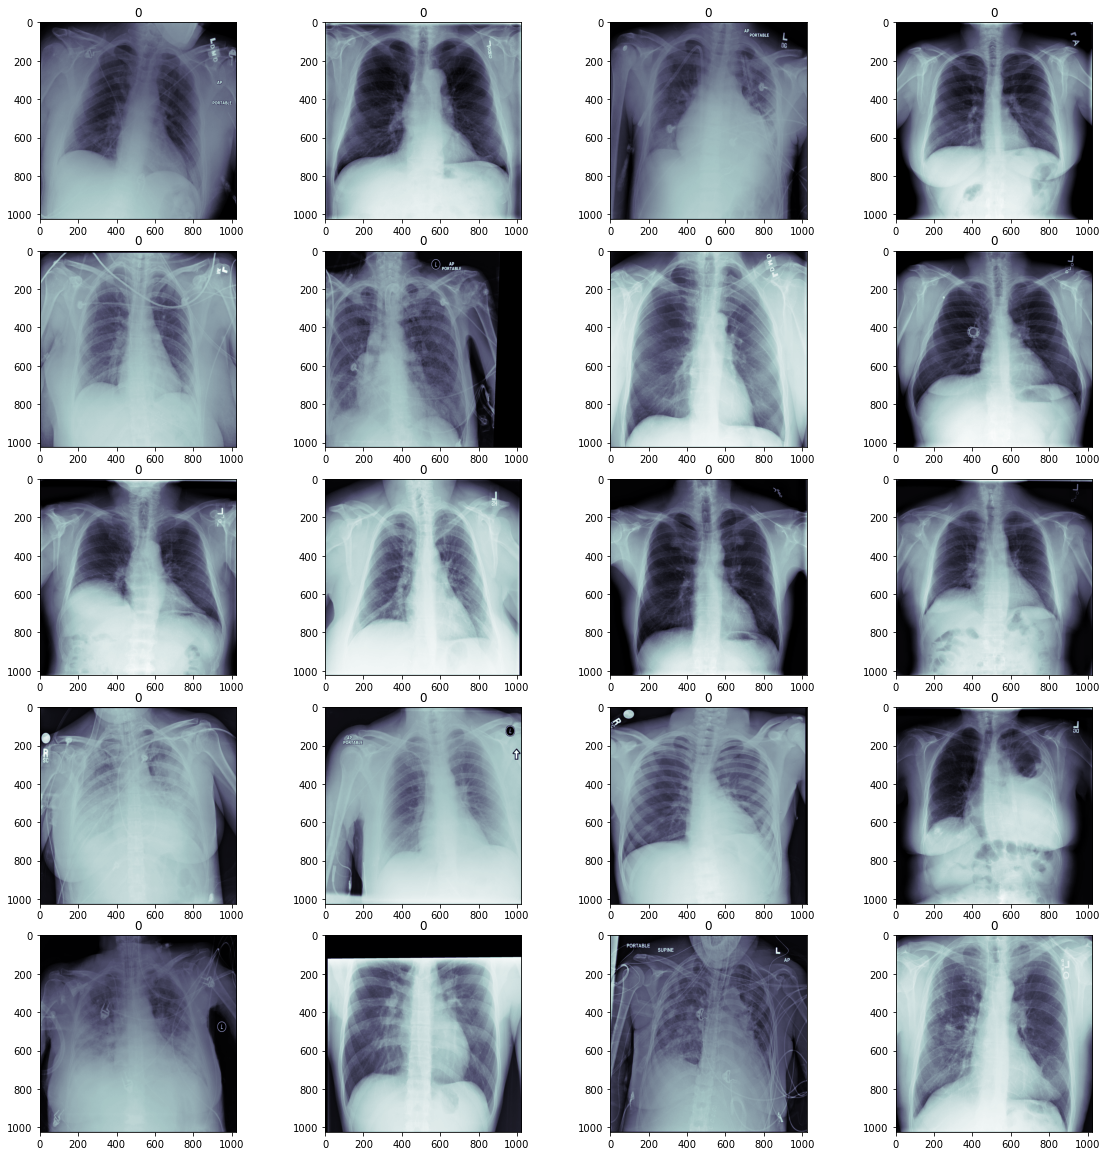

In [55]:

## image view of plian
fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
plt.tight_layout()
imgs = all_xray_df.image_path.sample(50)
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='bone')
    ax.set_title(all_xray_df.iloc[ind].pneumonia)
    ind=ind+1

In [57]:
## X-ray image augmentation for trainig dataset

def get_train_gen(train_df, image_dir, x_cols, y_cols, shuffle=True, batch_size=64, seed=1, target_w = 224, target_h = 224):
    print("getting train generator...") 
    # normalize images
    image_gen = ImageDataGenerator(rescale=1./255, 
                                   horizontal_flip = True, 
                                   vertical_flip = False, 
                                   height_shift_range= 0.1, 
                                   width_shift_range=0.1,
                                   rotation_range=10,
                                   shear_range = 0.1,
                                   zoom_range=0.1)
    
    # flow from directory with specified batch size
    # and target image size
    train_gen = image_gen.flow_from_dataframe(
            dataframe=train_df,
            directory=image_dir,
            x_col=x_cols,
            y_col=y_cols,
            class_mode='raw',
            shuffle=shuffle,
            batch_size=batch_size,
            seed=seed,
            target_size=(target_w,target_h))
    
    return train_gen


In [58]:
## Xray image augmentation for Validation 


def get_valid_gen(valid_df, image_dir, x_cols, y_cols, batch_size=64, seed=1, target_w = 224, target_h = 224):
    print("getting valid generators...")

    # get data sample
    batch = train_gen.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_gen = ImageDataGenerator(rescale=1./255,
                                   )
    
    # get test generator
    valid_gen = image_gen.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_cols,
            y_col=y_cols,
            class_mode='raw',
            batch_size=batch_size,
            shuffle=True,
            seed=seed,
            target_size=(target_w,target_h))

    return valid_gen

In [59]:
train_gen = get_train_gen(train_df, None, 'image_path', 'pneumonia')
valid_gen= get_valid_gen(valid_df, None, 'image_path', 'pneumonia')

#train_gen = get_train_gen(train_df, None, 'image_path', 'pneumonia')
#valid_gen = get_valid_gen(valid_tf, None, 'image_path', 'pneumonia')

getting train generator...
Found 2290 validated image filenames.
getting valid generators...
Found 1430 validated image filenames.


In [60]:
t_x, t_y = next(train_gen)
print('Train',t_x.min(), t_x.max(), t_x.mean(), t_x.std())

Train 0.0 1.0 0.510408 0.25040054


In [61]:
valX, valY = valid_gen.next()

In [62]:
valY

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0])

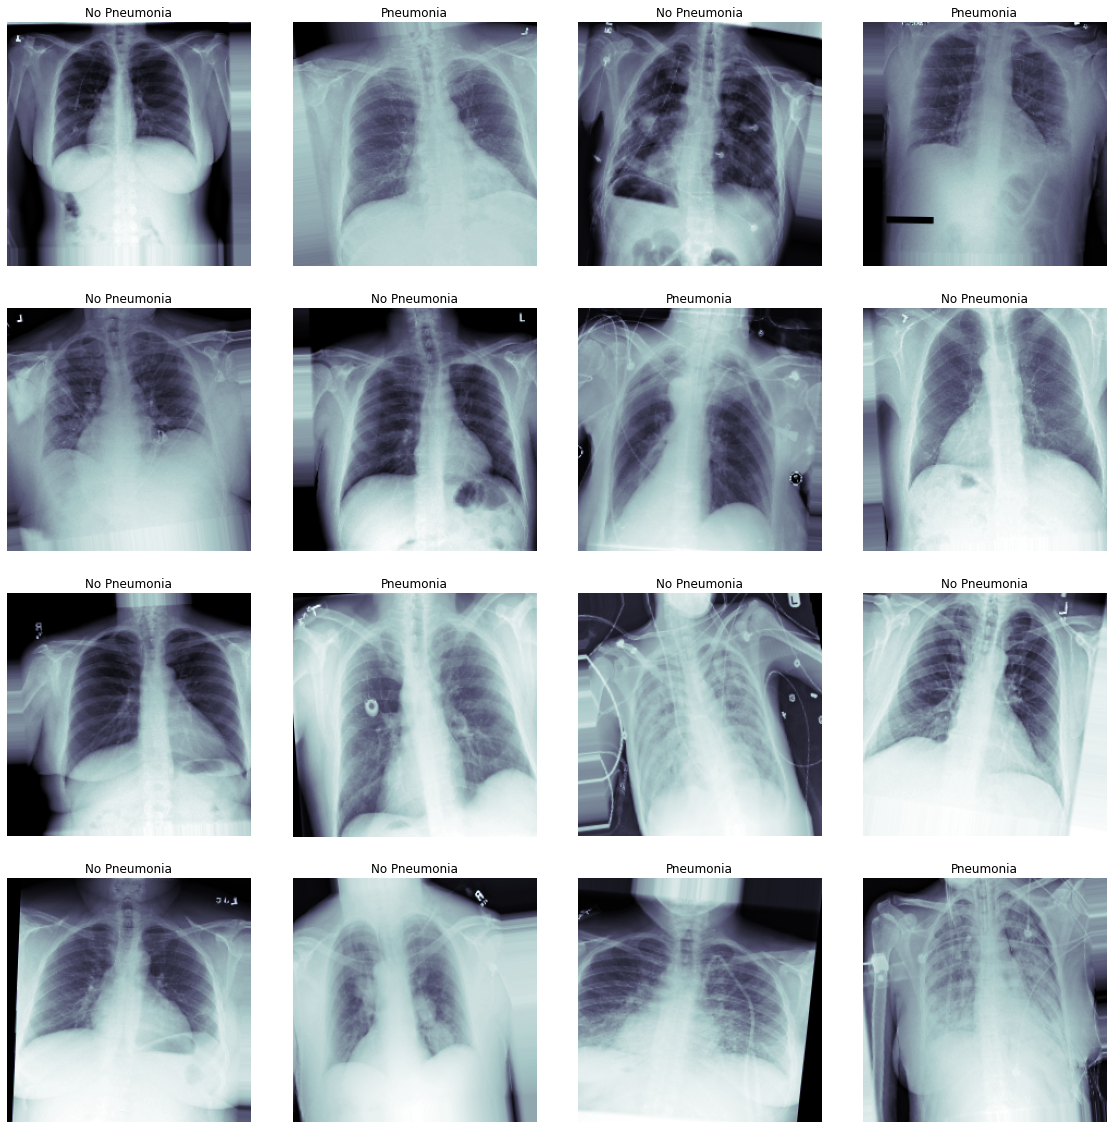

In [63]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4,4, figsize = (16,16))
plt.tight_layout()
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap='bone')
    if c_y==1:
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')
            

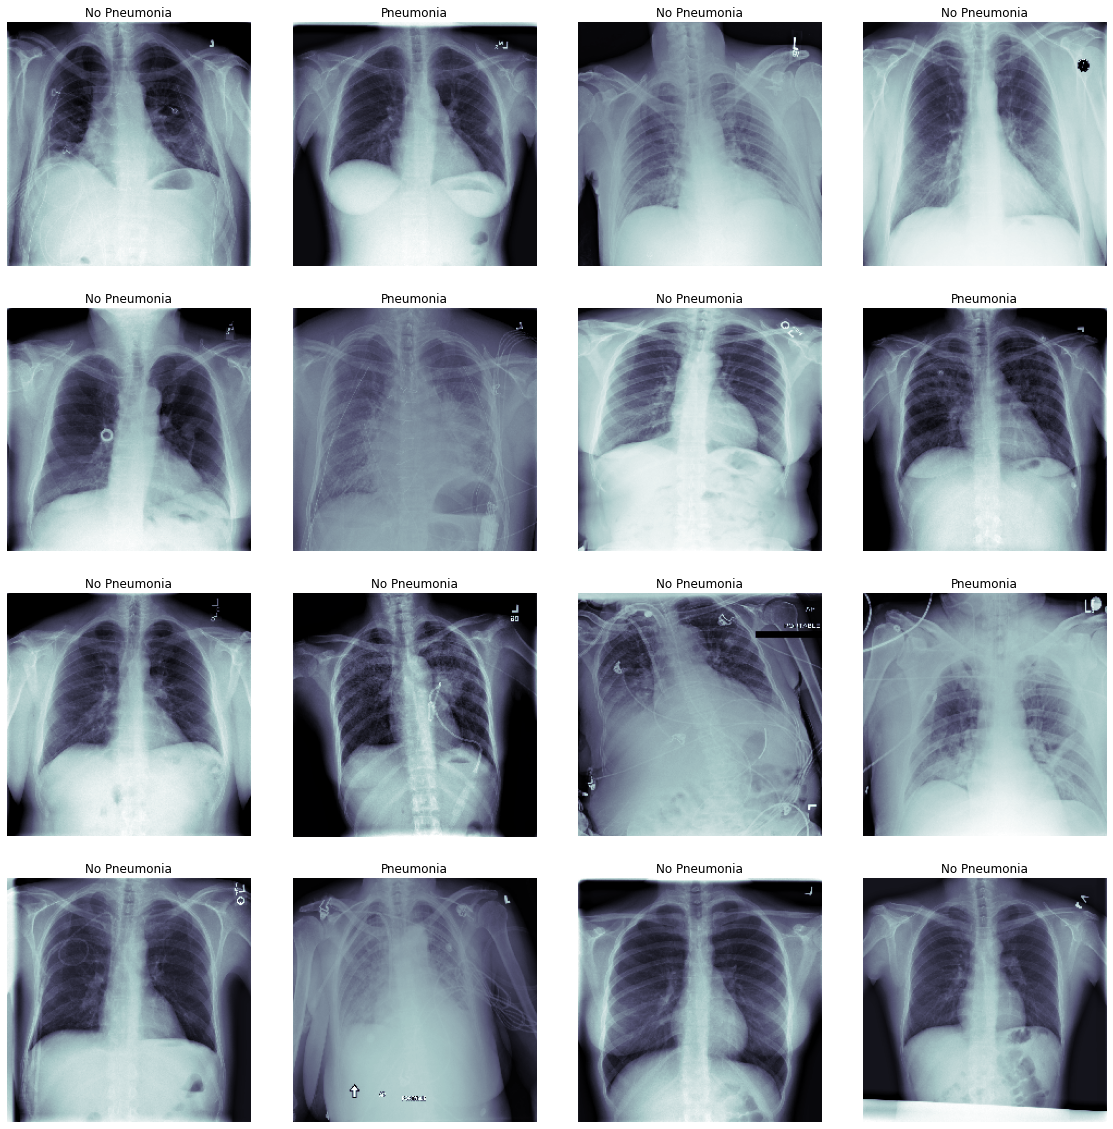

In [64]:
v_x, v_y = next(valid_gen)
fig, m_axs = plt.subplots(4,4, figsize = (16,16))
plt.tight_layout()
for (c_x, c_y, c_ax) in zip(v_x, v_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap='bone')
    if c_y==1:
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [65]:
## Loading pretrained model VGG16

def load_pretrained_model(include_top, weights, lay_of_interest ):
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    model = VGG16(include_top=include_top, weights=weights)
    model.summary()
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs=model.input,
                       outputs=transfer_layer.output)
    
    return vgg_model

In [66]:
vgg_model = load_pretrained_model(True,'imagenet', 'block5_pool')

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [67]:
vgg_model.layers

In [68]:
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [69]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [70]:
my_model = Sequential()
my_model.add(vgg_model)
my_model.add(Flatten())

my_model.add(Dropout(0.5))
my_model.add(Dense(1024, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(512, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(256, activation='relu'))

my_model.add(Dense(1, activation='sigmoid'))

In [71]:
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [72]:
my_model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

In [73]:
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_binary_accuracy', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'max', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=10)

callbacks_list = [checkpoint, early]

In [74]:
weight_path

'xray_class_my_model.best.hdf5'

In [75]:
history = my_model.fit_generator(train_gen, validation_data = (valX, valY),  epochs = 10, callbacks=callbacks_list)

Epoch 1/10
36/36 [==============================] - 63s 2s/step - loss: 0.7920 - binary_accuracy: 0.5096 - val_loss: 0.5584 - val_binary_accuracy: 0.7969

Epoch 00001: val_binary_accuracy improved from -inf to 0.79688, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
36/36 [==============================] - 58s 2s/step - loss: 0.7280 - binary_accuracy: 0.5266 - val_loss: 0.6692 - val_binary_accuracy: 0.6094

Epoch 00002: val_binary_accuracy did not improve from 0.79688
Epoch 3/10
36/36 [==============================] - 58s 2s/step - loss: 0.6988 - binary_accuracy: 0.5380 - val_loss: 0.6222 - val_binary_accuracy: 0.7031

Epoch 00003: val_binary_accuracy did not improve from 0.79688
Epoch 4/10
36/36 [==============================] - 58s 2s/step - loss: 0.6928 - binary_accuracy: 0.5620 - val_loss: 0.5838 - val_binary_accuracy: 0.7656

Epoch 00004: val_binary_accuracy did not improve from 0.79688
Epoch 5/10
36/36 [==============================] - 57s 2s/step - loss: 0.6832 - bin

In [78]:
def plot_history(history):
    P = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, P), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, P), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, P), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, P), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

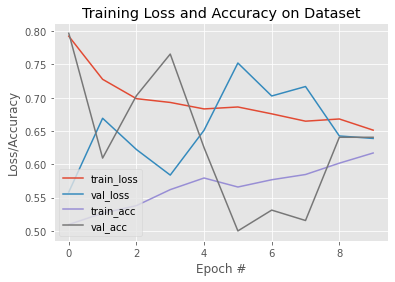

In [79]:
plot_history(history)

In [81]:
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

64/64 [==============================] - 4s 55ms/step


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [88]:
def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

def key_metrics(valY, pred_X):
    
    acc = accuracy_score(valY, np.round(pred_Y))*100
    cm = confusion_matrix(valY, np.round(pred_Y),labels=[0,1])
    tn,fp,fn,tp = cm.ravel()
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
    
    print('TRAIN METRIC ----------------------')
    print('Train acc: {}%'.format(np.round((history.history['binary_accuracy'][-1])*100, 2)))
    print('TEST METRICS ----------------------')
    print('Accuracy: {}%'.format(acc))
    
    print('True Negative: {}'.format(tn))
    print('True Positive: {}'.format(tp))
    print('False Negative: {}'.format(fn))
    print('False Positive: {}'.format(fp))
    print(' ')
    print('Sensitivity: {}'.format(sensitivity))
    print(' ')
    print('specificity: {}'.format(specificity))
    print(' ')
    print('Confusion Matrix: {}'.format(cm))
    print(' ')
     
    print('Threshold where Precision is 0.8--------------------')
    precision_value = 0.8
    idx = (np.abs(precision - precision_value)).argmin() 
    print('Precision is: '+ str(precision[idx]))
    print('Recall is: '+ str(recall[idx]))
    print('Threshold is: '+ str(thresholds[idx]))
    print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))
    print(' ')
    
    print('Threshold where Recall is 0.8--------------------')
    recall_value = 0.8
    idx = (np.abs(recall - recall_value)).argmin() 
    print('Precision is: '+ str(precision[idx]))
    print('Recall is: '+ str(recall[idx]))
    print('Threshold is: '+ str(thresholds[idx]))
    print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

In [89]:
key_metrics(valY, pred_Y)

TRAIN METRIC ----------------------
Train acc: 61.7%
TEST METRICS ----------------------
Accuracy: 79.6875%
True Negative: 51
True Positive: 0
False Negative: 13
False Positive: 0
 
Sensitivity: 0.0
 
specificity: 1.0
 
Confusion Matrix: [[51  0]
 [13  0]]
 
Threshold where Precision is 0.8--------------------
Precision is: 1.0
Recall is: 0.07692307692307693
Threshold is: 0.4328137
F1 Score is: 0.14285714285714288
 
Threshold where Recall is 0.8--------------------
Precision is: 0.2564102564102564
Recall is: 0.7692307692307693
Threshold is: 0.34997073
F1 Score is: 0.38461538461538464


In [90]:
def plot_auc(valY, pred_Y):
    lw=2
    fig, c_ax = plt.subplots(1,1,figsize = (9,9))
    fpr,tpr, thresholds = roc_curve(valY, pred_Y)
    c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % ('pneumonia', auc(fpr,tpr)))
    plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

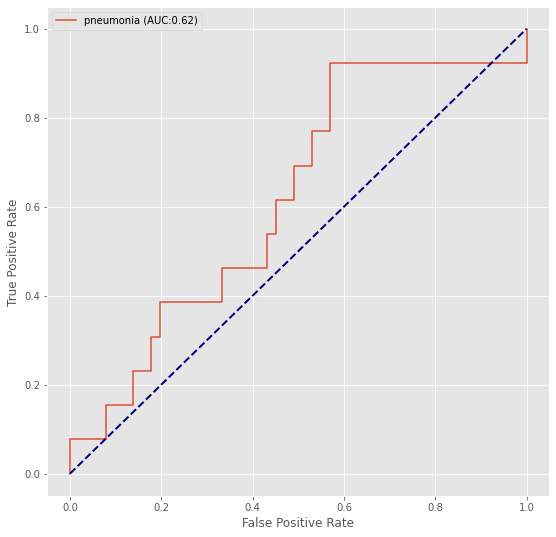

In [91]:
plot_auc(valY, pred_Y)

In [92]:
def plot_pr(Valy, pred_y):
    fig, c_ax = plt.subplots(1,1,figsize = (9,9))
    precision, recall, thersholds = precision_recall_curve(valY, pred_Y)
    c_ax.plot(precision, recall, label='%s (AP Score:%0.2f)' % ('pneumonia', average_precision_score(valY,pred_Y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

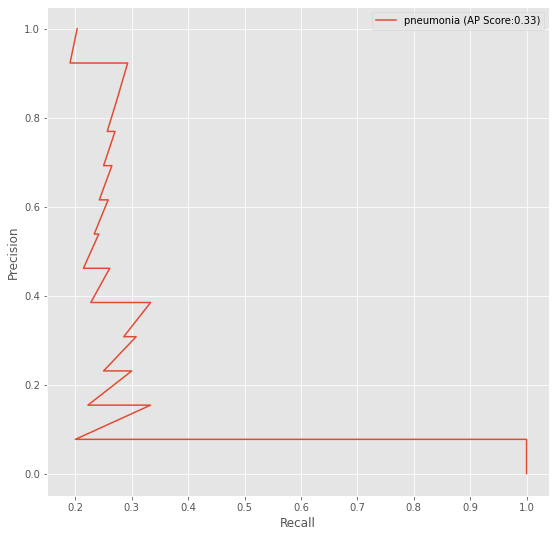

In [93]:
plot_pr(valY, pred_Y)

In [94]:
def plot_f1_thres_curve(valY, pred_Y):
    fig, c_ax = plt.subplots(1, 1, figsize=(9,9))
    precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
    precision = precision[:-1]
    recall = recall[:-1]
    f1_scores = 2*(precision*recall/(precision+recall))
    c_ax.plot(thresholds, f1_scores, label='F1-Scores - Thresholds Curve')
    c_ax.legend()
    c_ax.set_xlabel('Threshold')
    c_ax.set_ylabel('F1-Scores')

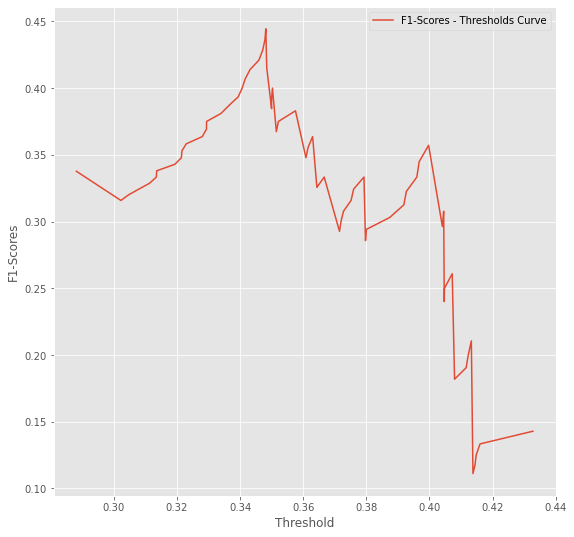

In [95]:
plot_f1_thres_curve(valY, pred_Y)

In [96]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)